# 2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

%matplotlib inline

MNISTはデータサイズが大きいので、いったん[Optical Recognition of Handwritten Digits Data Set](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)のコピーである、[sklearn.datasets.load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)を使って、正しく動いているか検証してみましょう。

0


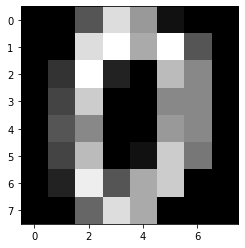

1


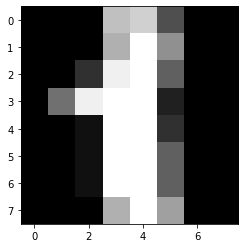

2


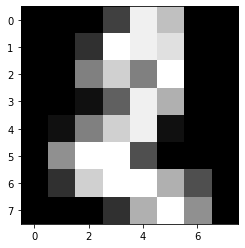

3


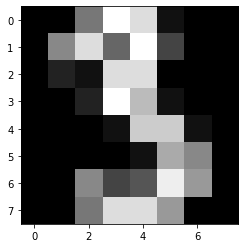

4


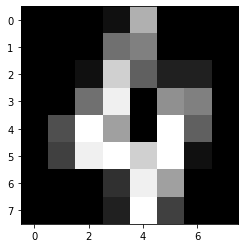

5


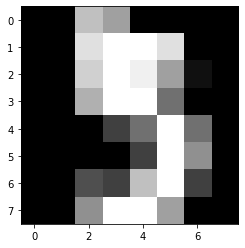

6


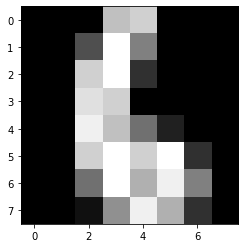

7


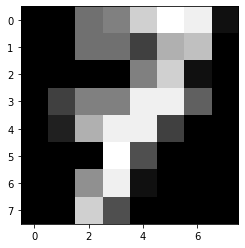

8


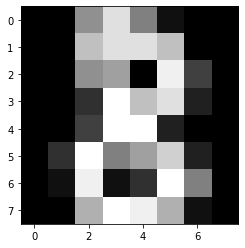

9


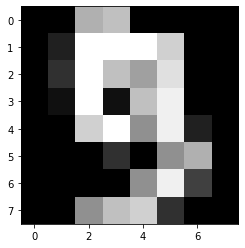

In [2]:
X,y = load_digits(n_class = 10, return_X_y = True)
X = X.reshape((-1,8,8))
for i in range(10):
    print(y[i])
    plt.imshow(X[i],"gray")
    plt.show()

標準化/正規化ももちろん必須なので、してあげましょう。

モノクロ画像なので、チャンネル側がありませんが、reshapeして、チャンネル方向に拡張してください。

In [3]:
X[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [4]:
X.shape

(1797, 8, 8)

In [5]:
y.shape

(1797,)

In [6]:
#データ型をfloatに変換
X = X.astype(np.float)
#0-1の範囲に正規化
X /= 16
#4次元化
X = X[:, np.newaxis, :, :]

In [7]:
X.shape

(1797, 1, 8, 8)

In [8]:
#訓練データとテストデータに分ける
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [9]:
X_train.shape

(1347, 1, 8, 8)

In [10]:
#one-hot化

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

## 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

ai,j,m: 出力される配列のi行j列、mチャンネルの値


i: 配列の行方向のインデックス


j: 配列の列方向のインデックス


m: 出力チャンネルのインデックス


K: 入力チャンネル数


Fh,Fw: 高さ方向（h）と幅方向（w）のフィルタのサイズ


x(i+s),(j+t),k: 入力の配列の(i+s)行(j+t)列、kチャンネルの値


ws,t,k,m: 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


bm: mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

α: 学習率

$\frac{\partial L}{\partial w_{s,t,k,m}}$: ws,t,k,mに関する損失 Lの勾配

勾配$\frac{\partial L}{\partial w_{s,t,k,m}}$や$\frac{\partial L}{\partial b_{m}}$を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$: 勾配の配列のi行j列、mチャンネルの値

Nout,h,Nout,w: 高さ方向（h）と幅方向（w）の出力のサイズ

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$: 前の層に流す誤差の配列のi列j行、kチャンネルの値

M: 出力チャンネル数

ただし、i−s<0または i−s>Nout,h−1または j−t<0またはj−t>Nout,w−1のとき$\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$です。


In [11]:
class CNN_2d_:
    def __init__(self, w, b, optimizer, stride=1, pad=0):
        self.w = w
        self.b = b
        self.optimizer = optimizer
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        #データ数,ch,高さ,横幅
        FN, C, FH, FW = self.w.shape
        N, C, H, W = x.shape
        #出力サイズ
        out_h = calc_out_shape(H, self.pad, FH, self.stride)
        out_w = calc_out_shape(W, self.pad, FW, self.stride)
        #デー タを変換
        #col (N*out_h*out_w, C*FH*FW)
        #col_w (C*FH*FW, FN)
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_w = self.w.reshape(FN, -1).T
        #(N*out_h*out_w, FN)
        A = np.dot(col, col_w) + self.b
        #2次元の出力データを元に戻す
        #(N, out_h, out_w, FN)->(N, FN, out_h, out_w)
        A = A.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_w = col_w
        
        return A
        
    def backward(self, dout):
        #データ数,ch,高さ,横幅
        FN, C, FH, FW = self.w.shape
        #(N, FN, out_h, out_w)->(N, out_h, out_w, FN)->(N*out_h*out_w, FN)
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        #(C*FH*FW, N*out_h*out_w)@(N*out_h*out_w, FN)->(C*FH*FW, FN)
        self.dw = np.dot(self.col.T, dout)
        #(C*FH*FW, FN)->(FN, C*FH*FW)->(FN, C, FH, FW)
        self.dw = self.dw.transpose(1, 0).reshape(FN, C, FH, FW)
        self.db = np.sum(dout, axis=0)
        #(N*out_h*out_w, FN)@(FN, C*FH*FW)->(N*out_h*out_w, C*FH*FW)
        dcol = np.dot(dout, self.col_w.T)
        #(N*out_h*out_w, C*FH*FW)->(N, C, H, W)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        self = self.optimizer.update(self)
        
        return dx

In [12]:
class SGD_Conv2d:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
    
        """
        layer.w -= self.lr * layer.dw
        layer.b -= self.lr * layer.db
        
        return layer

### im2col関数について
CNNの畳み込み演算において複雑なループ処理を避けるため、フィルター適用領域ごとに一列のデータになるよう変換する関数。

入力データとフィルターにこの関数を適用することで、行列のドット演算で一気に畳み込み演算が行えます。

[im2col関数の理解](https://qiita.com/kurumen-b/items/236c6255959a266cefaa)

In [13]:
def im2col(x, FH, FW, stride=1, pad=0):
    #データ数,ch,高さ,横幅
    N, C, H, W = x.shape
    #出力サイズ
    out_h = calc_out_shape(H, pad, FH, stride)
    out_w = calc_out_shape(W, pad, FW, stride)

    img = np.pad(x, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')   
    col = np.zeros((N, C, FH, FW, out_h, out_w))

    for y in range(FH):
        y_max = y + stride*out_h
        for x in range(FW):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [14]:
def im2col2(x, FH, FW, stride=1):
    #データ数,ch,高さ,横幅
    N, C, H, W = x.shape
    #出力サイズ
    out_h = calc_out_shape(H, pad, FH, stride)
    out_w = calc_out_shape(W, pad, FW, stride)

    col = np.zeros([out_h * out_w * N, C * FH * FW])

    for n in range(N):
        for i in range(out_h):
            for j in range(out_w):
                patch = x[n, :, i*stride : i*stride + FH, 
                         j*stride : j*stride + FH]
                
                col[i*out_w + j, :] = np.reshape(patch, -1)
    return col

In [15]:
def col2im(col, x, FH, FW, stride=1, pad=0):
    N, C, H, W = x

    out_h = calc_out_shape(H, pad, FH, stride)
    out_w = calc_out_shape(W, pad, FW, stride)
    col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(FH):
        y_max = y + stride*out_h
        for x in range(FW):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] = col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

以下色々とshapeの確認

In [22]:
data = np.random.rand(1, 1, 7, 7) * 100 // 1

print('========== input ==========\n', data)
print('=====================')
filter_h = 3
filter_w = 3
stride = 2
pad = 0
col = im2col(data, FH=filter_h, FW=filter_w, stride=stride, pad=pad)
col2 = im2col2(data, FH=filter_h, FW=filter_w, stride=stride)
print('========== col ==========\n', col)
print('=====================')
print('========== col2 ==========\n', col2)
print('=====================')

========== input ==========
 [[[[76. 71. 76. 42. 23. 12. 33.]
   [50. 44. 20. 27. 56. 59. 49.]
   [58. 32. 83. 46. 26.  0. 21.]
   [59. 41. 17. 30. 73. 97.  3.]
   [84. 64. 94.  1. 96.  3. 37.]
   [90. 39. 70. 79. 67.  4. 59.]
   [96. 58. 54. 23. 67. 48. 39.]]]]
========== col ==========
 [[76. 71. 76. 50. 44. 20. 58. 32. 83.]
 [76. 42. 23. 20. 27. 56. 83. 46. 26.]
 [23. 12. 33. 56. 59. 49. 26.  0. 21.]
 [58. 32. 83. 59. 41. 17. 84. 64. 94.]
 [83. 46. 26. 17. 30. 73. 94.  1. 96.]
 [26.  0. 21. 73. 97.  3. 96.  3. 37.]
 [84. 64. 94. 90. 39. 70. 96. 58. 54.]
 [94.  1. 96. 70. 79. 67. 54. 23. 67.]
 [96.  3. 37. 67.  4. 59. 67. 48. 39.]]
========== col2 ==========
 [[76. 71. 76. 50. 44. 20. 58. 32. 83.]
 [76. 42. 23. 20. 27. 56. 83. 46. 26.]
 [23. 12. 33. 56. 59. 49. 26.  0. 21.]
 [58. 32. 83. 59. 41. 17. 84. 64. 94.]
 [83. 46. 26. 17. 30. 73. 94.  1. 96.]
 [26.  0. 21. 73. 97.  3. 96.  3. 37.]
 [84. 64. 94. 90. 39. 70. 96. 58. 54.]
 [94.  1. 96. 70. 79. 67. 54. 23. 67.]
 [96.  3. 37. 67. 

In [23]:
w_org = np.random.rand(1, 2, 3, 4) * 100 // 1
w_org, w_org.shape

(array([[[[ 0., 35., 95., 98.],
          [14., 59., 51., 55.],
          [68., 84., 96., 43.]],
 
         [[65., 42., 22., 44.],
          [ 3., 58., 98., 73.],
          [65., 96., 57., 59.]]]]),
 (1, 2, 3, 4))

In [24]:
wt = w_org.T
wt, wt.shape

(array([[[[ 0.],
          [65.]],
 
         [[14.],
          [ 3.]],
 
         [[68.],
          [65.]]],
 
 
        [[[35.],
          [42.]],
 
         [[59.],
          [58.]],
 
         [[84.],
          [96.]]],
 
 
        [[[95.],
          [22.]],
 
         [[51.],
          [98.]],
 
         [[96.],
          [57.]]],
 
 
        [[[98.],
          [44.]],
 
         [[55.],
          [73.]],
 
         [[43.],
          [59.]]]]),
 (4, 3, 2, 1))

In [25]:
w = w_org.transpose(0, 3, 1, 2)
w, w.shape

(array([[[[ 0., 14., 68.],
          [65.,  3., 65.]],
 
         [[35., 59., 84.],
          [42., 58., 96.]],
 
         [[95., 51., 96.],
          [22., 98., 57.]],
 
         [[98., 55., 43.],
          [44., 73., 59.]]]]),
 (1, 4, 2, 3))

In [26]:
w = w_org.reshape(3, -1)
w, w.shape

(array([[ 0., 35., 95., 98., 14., 59., 51., 55.],
        [68., 84., 96., 43., 65., 42., 22., 44.],
        [ 3., 58., 98., 73., 65., 96., 57., 59.]]),
 (3, 8))

## 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

Nout: 出力のサイズ（特徴量の数）

Nin: 入力のサイズ（特徴量の数）

P: ある方向へのパディングの数

F: フィルタのサイズ

S: ストライドのサイズ

hが高さ方向、wが幅方向である


In [27]:
def calc_out_shape(n_in, p, f, s):
    n_out = ((n_in + 2*p - f) // s) + 1
    return n_out

In [28]:
#確認
print(17/3)
print(17//3)
print(int(17/3))

5.666666666666667
5
5


In [29]:
X_train.shape

(1347, 1, 8, 8)

In [30]:
#データ数,ch数,高さ,横幅

tstX = X_train[:20]
print('========== input ==========\n', tstX.shape)

w = np.random.randn(10, 1, 3, 3)
b = np.zeros(10)
print('========== filter ==========\n', w.shape)

cnn2d = CNN_2d_(w, b, SGD_Conv2d)
tstA = cnn2d.forward(tstX)
print('========== 出力 ==========\n', tstA.shape)


========== input ==========
 (20, 1, 8, 8)
========== filter ==========
 (10, 1, 3, 3)
========== 出力 ==========
 (20, 10, 6, 6)


## 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

Pi,j: i行j列への出力する場合の入力配列のインデックスの集合。 Sh×Swの範囲内の行（p）と列（q）

Sh,Sw: 高さ方向（h）と幅方向（w）のストライドのサイズ

(p,q)∈Pi,j: Pi,jに含まれる行（p）と列（q）のインデックス

ai,j,m: 出力される配列のi行j列、kチャンネルの値

xp,q,k: 入力の配列のp行q列、kチャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス (p,q)を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。


In [31]:
class MaxPooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = calc_out_shape(n_in=H, p=0, f=self.pool_h, s=self.stride)
#         out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = calc_out_shape(n_in=W, p=0, f=self.pool_w, s=self.stride)
#         out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        #colの1次元目の軸ごとに最大値を抽出
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [32]:
#データ数,ch数,高さ,横幅

tstX = X_train[:20]
print('========== input ==========\n', tstX.shape)

w = np.random.randn(10, 1, 3, 3)
b = np.zeros(10)
print('========== filter ==========\n', w.shape)

cnn2d = CNN_2d_(w, b, SGD_Conv2d)
tstA = cnn2d.forward(tstX)
print('========== 出力 ==========\n', tstA.shape)

mp = MaxPooling(4, 4, 2)
tstA2 = mp.forward(tstA)
print('========== プーリング(4×4, stride=2) ==========\n', tstA2.shape)

========== input ==========
 (20, 1, 8, 8)
========== filter ==========
 (10, 1, 3, 3)
========== 出力 ==========
 (20, 10, 6, 6)
========== プーリング(4×4, stride=2) ==========
 (20, 10, 2, 2)


In [33]:
#データ数,ch数,高さ,横幅

tstX = X_train[:20]
print('========== input ==========\n', tstX.shape)

w = np.random.randn(10, 1, 3, 3)
b = np.zeros(10)
print('========== filter ==========\n', w.shape)

cnn2d = CNN_2d_(w, b, SGD_Conv2d)
tstA = cnn2d.forward(tstX)
print('========== 出力 ==========\n', tstA.shape)

mp = MaxPooling(2, 2, 1)
tstA2 = mp.forward(tstA)
print('========== プーリング(2×2, stride=1) ==========\n', tstA2.shape)

========== input ==========
 (20, 1, 8, 8)
========== filter ==========
 (10, 1, 3, 3)
========== 出力 ==========
 (20, 10, 6, 6)
========== プーリング(2×2, stride=1) ==========
 (20, 10, 5, 5)


## 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

## 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [34]:
class Flatten():
    def __init__(self):
        self.X = None
        self.N = None
        self.C = None
        self.H = None
        self.W = None
    
    def forward(self, X):
        self.N, self.C, self.H, self.W = X.shape    
        self.X = X.reshape(self.N, -1)                    
        
        return self.X
    
    def backward(self, dout):
        return dout.reshape((self.N, self.C, self.H, self.W))

In [35]:
#データ数,ch数,高さ,横幅

tstX = X_train[:20]
print('========== input ==========\n', tstX.shape)

w = np.random.randn(10, 1, 3, 3)
b = np.zeros(10)
print('========== filter ==========\n', w.shape)

cnn2d = CNN_2d_(w, b, SGD_Conv2d)
tstA = cnn2d.forward(tstX)
print('========== 出力 ==========\n', tstA.shape)

mp = MaxPooling(2, 2, 1)
tstA2 = mp.forward(tstA)
print('========== プーリング(2×2, stride=1) ==========\n', tstA2.shape)

ft = Flatten()
tstA3 = ft.forward(tstA2)
print('========== 平滑化 ==========\n', tstA3.shape)

========== input ==========
 (20, 1, 8, 8)
========== filter ==========
 (10, 1, 3, 3)
========== 出力 ==========
 (20, 10, 6, 6)
========== プーリング(2×2, stride=1) ==========
 (20, 10, 5, 5)
========== 平滑化 ==========
 (20, 250)


## 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

In [36]:
#Full Connected Layer Class
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        #最適化手法(SGD, AdaGrad)を引数で受け取りインスタンス化
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        ##層の各ノードの偏微分係数をインスタンスで保持
        self.bZ = None      
        self.dA = None
        self.hw = 0
        self.hb = 0

        
    def forward(self, bZ):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """     
        #インスタンスに保存(パラメータ更新で使用)
        self.bZ = bZ.copy()
        #層の総入力
        A = np.dot(bZ, self.w) + self.b
        
#         print('self.b', self.b.shape)
#         print('self.w', self.w.shape)
#         print('A', A.shape)
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #インスタンスに保存(パラメータ更新で使用)
        self.dA = dA
        
        dZ = np.dot(dA, self.w.T)        
        
        # self.w, self.bの更新
        self = self.optimizer.update(self)
        return dZ

In [37]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #層の各ノードの偏微分係数を元に重みとバイアスを更新   
        layer.w -= self.lr * np.dot(layer.bZ.T, layer.dA) / len(layer.dA)
        layer.b -= np.mean(self.lr * layer.dA, axis=0)
    
        return layer

In [38]:
class ReLU:
    def __init__(self):
        #x<=0をTrue,x>0をFalseとする配列
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        #値渡し
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dx = dout.copy()
        
        dx[self.mask] = 0
        
        
        return dx

In [39]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = 1/np.sqrt(n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2) 
        return B

In [40]:
class Softmax:
    
    def forward(self, x):
        
        #softmax関数の計算
        c = np.max(x)
        #オーバーフロー対策
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1).reshape(-1, 1)
        z = exp_x / sum_exp_x
        
        return z
    
    def backward(self, dout, t):
        
        dx = dout - t
        
        loss = - np.sum(t * np.log(dout), axis=1)
        
        return dx, loss

In [41]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [42]:
class ConvInitializer:

    def __init__(self, FN, C, FH, FW, weight_init_std=0.01):
        self.weight_init_std = weight_init_std
        self.FN = FN
        self.C = C
        self.FH = FH
        self.FW = FW

    def W(self):
        w = self.weight_init_std * np.random.randn(self.FN, self.C, 
                                                   self.FH, self.FW)
        return w
    
    def B(self):
        b = np.zeros(self.FN)
        return b

In [43]:
ci = ConvInitializer(10, 1, 3, 3)
w1 = ci.W()
b1 = ci.B()

w1.shape, b1.shape

((10, 1, 3, 3), (10,))

In [44]:
class ScratchCNN_2d_Classifier:
    def __init__(self, lr, minibatch_size, filter_n, filter_w, filter_h, stride, 
                 n_nodes, pool_h, pool_w, pool_stride, sigma):
        self.lr = lr
        self.minibatch_size = minibatch_size
        self.n_nodes = n_nodes
        
        #filter数
        self.filter_n = filter_n
        #filter
        self.filter_w = filter_w
        #filter
        self.filter_h = filter_h
        
        self.stride = stride
        
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.pool_stride = pool_stride
        
        self.sigma = sigma
    
    def fit(self,X,y,epoch):
        
        self.n_features = X.shape[2]
        self.n_output = y.shape[1]
        
        ci = ConvInitializer(self.filter_n, X.shape[1], self.filter_w, self.filter_h)
        self.w = ci.W()
        self.b = ci.B()
        
        optimizer1 = SGD_Conv2d(self.lr)
        optimizer2 = SGD(self.lr)
        self.Conv = CNN_2d_(self.w, self.b, optimizer1)
        self.activation1 = ReLU()
        self.pool = MaxPooling(pool_h=self.pool_h, pool_w=self.pool_w, 
                               stride=self.pool_stride)
        self.flatten = Flatten()
        
        
        N, C, H, W = X.shape
        out_h = calc_out_shape(n_in=H, p=0, f=self.filter_h, s=self.stride)
        out_w = calc_out_shape(n_in=W, p=0, f=self.filter_w, s=self.stride)    
        
        out_h2 = calc_out_shape(n_in=out_h, p=0, f=self.pool_h, s=self.pool_stride)
        out_w2 = calc_out_shape(n_in=out_w, p=0, f=self.pool_w, s=self.pool_stride)       

        nodes = self.filter_n * out_h2 * out_w2
        
        self.FC2 = FC(nodes, self.n_nodes, XavierInitializer(), optimizer2)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes, self.n_output, XavierInitializer(), optimizer2)
        self.activation3 = Softmax()
        
        self.cost_list = []
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y, self.minibatch_size)
            for mini_X, mini_y in get_mini_batch:
                A1 = self.Conv.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                Z1_p = self.pool.forward(Z1)
                Z1_f = self.flatten.forward(Z1_p)
                A2 = self.FC2.forward(Z1_f)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                #Loss Curvを描くための処理
            
                # 交差エントロピー誤差とソフトマックスを合わせている
                dA3, loss = self.activation3.backward(Z3, mini_y) 
                dZ2 = self.FC3.backward(dA3)                
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dZ1_f = self.flatten.backward(dZ1)
                dZ1_p = self.pool.backward(dZ1_f)
                dA1 = self.activation1.backward(dZ1_p)
                dZ0 = self.Conv.backward(dA1) # dZ0は使用しない
            
            self.cost_list.append(np.mean(loss))
            
    def predict(self,X):
        A1 = self.Conv.forward(X)
        Z1 = self.activation1.forward(A1)
        Z1_p = self.pool.forward(Z1)
        Z1_f = self.flatten.forward(Z1_p)
        A2 = self.FC2.forward(Z1_f)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        out = self.activation3.forward(A3)
        y = np.argmax(out, axis=1)
        
        return y

In [45]:
scnnc = ScratchCNN_2d_Classifier(lr=0.005, minibatch_size=100, filter_n=10, 
                             filter_w=5, filter_h=5, stride=1, n_nodes=50, pool_h=2, pool_w=2, pool_stride=1, sigma=0.01)

In [46]:
scnnc.fit(X_train, y_train_one_hot, 50)

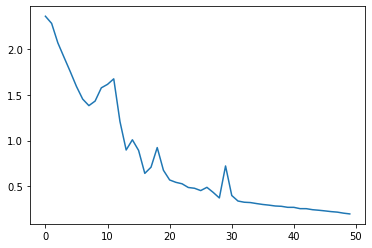

In [47]:
plt.plot(range(50), scnnc.cost_list)
plt.show()

In [48]:
from sklearn.metrics import accuracy_score

In [49]:
# 予測
y_pred = scnnc.predict(X_test)

# print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_test, y_pred))

0.9177777777777778


#### MNISTを学習・推定させる

In [50]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#データ型をfloatに変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
#0-1の範囲に正規化
X_train /= 255
X_test /= 255
#4次元化
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

#訓練データと検証データに分割

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#one-hot化

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])

Using TensorFlow backend.
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packag

In [51]:
scnnc2 = ScratchCNN_2d_Classifier(lr=0.005, minibatch_size=100, filter_n=100, 
                             filter_w=20, filter_h=20, stride=1, n_nodes=50, pool_h=2, pool_w=2, pool_stride=1, sigma=0.01)

In [52]:
scnnc2.fit(X_train, y_train_one_hot, 10)

In [53]:
scnnc3 = ScratchCNN_2d_Classifier(lr=0.005, minibatch_size=100, filter_n=100, 
                             filter_w=20, filter_h=20, stride=1, n_nodes=50, pool_h=2, pool_w=2, pool_stride=1, sigma=0.01)

In [54]:
scnnc3.fit(X_val, y_val_one_hot, 10)

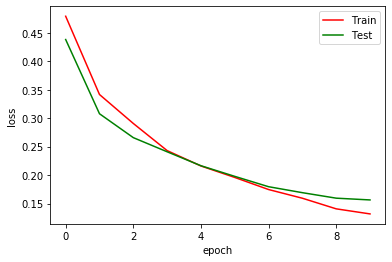

In [55]:
plt.plot(range(10), scnnc2.cost_list, color='r', label='Train')
plt.plot(range(10), scnnc3.cost_list, color='g', label='Test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [56]:
# 予測
y_pred = scnnc2.predict(X_test)

# print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_test, y_pred))

0.9581


lossは順調に減少し、accuracyも高い値を示した。

## 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。


Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.

※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数


## 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。


《参考》


Applications - Keras Documentation

## 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.

- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

2.

- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

3.

- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

In [67]:
#問題1

# 入力サイズ : 144×144, 3チャンネル
in_width = 144
in_height = 144
in_ch = 3

# フィルタサイズ : 3×3, 6チャンネル
f_width = 3
f_height = 3
f_ch = 6

# ストライド : 1  パディング : なし
stride = 1
pad = 0

# 出力サイズ
out_width = calc_out_shape(n_in=in_width, p=pad, f=f_width, s=stride)
out_height = calc_out_shape(n_in=in_height, p=pad, f=f_height, s=stride)
out_ch = f_ch / in_ch
#パラメータ数
n_params = f_width * f_height * in_ch * out_ch + out_ch

print('出力サイズ: {} x {} x {}'.format(out_height, out_width, out_ch))
print('パラメータ数: {}'.format(n_params))

出力サイズ: 142 x 142 x 2.0
パラメータ数: 56.0


In [68]:
#問題2

# 入力サイズ : 60×60, 24チャンネル
in_width = 60
in_height = 60
in_ch = 24

# フィルタサイズ : 3×3, 48チャンネル
f_width = 3
f_height = 3
f_ch = 48

# ストライド : 1  パディング : なし
stride = 1
pad = 0

# 出力サイズ
out_height = calc_out_shape(in_height, pad, f_height, stride)
out_width = calc_out_shape(in_width, pad, f_width, stride)
out_ch = f_ch / in_ch
#パラメータ数
n_params = f_width * f_height * in_ch * out_ch + out_ch

print('出力サイズ: {} x {} x {}'.format(out_height, out_width, out_ch))
print('パラメータ数: {}'.format(n_params))

出力サイズ: 58 x 58 x 2.0
パラメータ数: 434.0


In [69]:
#問題3

# 入力サイズ : 20×20, 10チャンネル
in_width = 20
in_height = 20
in_ch = 10

# フィルタサイズ : 3×3, 20チャンネル
f_width = 3
f_height = 3
f_ch = 20

# ストライド : 2  パディング : なし
stride = 2
pad = 0

# 出力サイズ
out_height = calc_out_shape(in_height, pad, f_height, stride)
out_width = calc_out_shape(in_width, pad, f_width, stride)
out_ch = f_ch / in_ch
#パラメータ数
n_params = f_width * f_height * in_ch * out_ch + out_ch

print('出力サイズ: {} x {} x {}'.format(out_height, out_width, out_ch))
print('パラメータ数: {}'.format(n_params))

出力サイズ: 9 x 9 x 2.0
パラメータ数: 182.0


## 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果